# مشروع توقع بيع ام شراء خلال الشموع القادمة لتحقيق نسبة معينة

## استدعاء ملف الاسعار وتحويله من شموع يبانية الى هيكين اشي

In [2]:
import pandas as pd
df= pd.read_csv(r"C:\Users\Access\Documents\AI ROBOT\XAUUSD_Candlestick_1_M_BID_2020-1-1_2024-12-31.csv")

import pandas as pd

# --- دالة تجميع إلى 15 دقيقة ---
def resample_to_15min(df):
    df['Gmt time'] = pd.to_datetime(df['Gmt time'])
    df.set_index('Gmt time', inplace=True)

    df_15min = df.resample('15T').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()

    df_15min.reset_index(inplace=True)
    return df_15min

# --- دالة Heikin Ashi ---
def heikin_ashi(df):
    ha_df = pd.DataFrame()
    ha_df['Gmt time'] = df['Gmt time']
    ha_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

    ha_open = [(df['Open'].iloc[0] + df['Close'].iloc[0]) / 2]
    for i in range(1, len(df)):
        ha_open.append((ha_open[i - 1] + ha_df['Close'].iloc[i - 1]) / 2)

    ha_df['Open'] = ha_open
    ha_df['High'] = pd.concat([df['High'], ha_df['Open'], ha_df['Close']], axis=1).max(axis=1)
    ha_df['Low'] = pd.concat([df['Low'], ha_df['Open'], ha_df['Close']], axis=1).min(axis=1)
    ha_df['Volume'] = df['Volume']
    return ha_df[['Gmt time', 'Open', 'High', 'Low', 'Close']]

# --- تشغيل الخطوات ---
df_15min = resample_to_15min(df)
ha_df = heikin_ashi(df_15min)

# --- طباعة النتيجة ---
#print(ha_df.head(10))  # اطبع أول 10 صفوف
df = ha_df

C:\Users\Access\AppData\Local\Temp\ipykernel_22068\3091461040.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample('15T').agg({


In [3]:
df

,Gmt time,Open,High,Low,Close
0,2020-01-01 00:00:00,1516.915000,1516.915,1516.915000,1516.915
1,2020-01-01 00:15:00,1516.915000,1516.915,1516.915000,1516.915
2,2020-01-01 00:30:00,1516.915000,1516.915,1516.915000,1516.915
3,2020-01-01 00:45:00,1516.915000,1516.915,1516.915000,1516.915
4,2020-01-01 01:00:00,1516.915000,1516.915,1516.915000,1516.915
...,...,...,...,...,...
158248,2024-12-31 22:45:00,2624.227034,2624.255,2624.227034,2624.255
158249,2024-12-31 23:00:00,2624.241017,2624.255,2624.241017,2624.255
158250,2024-12-31 23:15:00,2624.248008,2624.255,2624.248008,2624.255
158251,2024-12-31 23:30:00,2624.251504,2624.255,2624.251504,2624.255


In [4]:
import pandas as pd
import pytz
from datetime import datetime

df['Gmt time'] = pd.to_datetime(df['Gmt time'])

df = df[~df['Gmt time'].dt.dayofweek.isin([5, 6])]

df["prev_time"] = df["Gmt time"].shift(1)
df["time_gap"] = (df["Gmt time"] - df["prev_time"]).dt.total_seconds() / 60 # بالدقايق

df.dropna(subset=["prev_time", "time_gap"], inplace=True)

df['date'] = df['Gmt time'].dt.date
df['hour'] = df['Gmt time'].dt.hour
df['minute'] = df['Gmt time'].dt.minute

# دالة لمعرفة هل اليوم في DST في منطقة زمنية معينة
def is_dst(date, tz_name):
    tz = pytz.timezone(tz_name)
    try:
        dt = datetime.combine(date, datetime.min.time())
        localized = tz.localize(dt, is_dst=None)
        return bool(localized.dst())
    except:
        return False



# نحسب كل جلسة كـ Boolean مستقل
def get_sessions(row):
    date = row['date']
    hour = row['hour']

    ny_dst = is_dst(date, "America/New_York")
    london_dst = is_dst(date, "Europe/London")
    sydney_dst = is_dst(date, "Australia/Sydney")

    # جلسة سيدني
    syd_start = 22 if sydney_dst else 21
    syd_end = (syd_start + 9) % 24
    if syd_start < syd_end:
        is_sydney = syd_start <= hour < syd_end
    else:
        is_sydney = (hour >= syd_start or hour < syd_end)

    # طوكيو: 00:00 – 09:00 GMT
    is_tokyo = 0 <= hour < 9

    # لندن
    london_start = 7 if london_dst else 8
    london_end = 16 if london_dst else 17
    is_london = london_start <= hour < london_end

    # نيويورك
    ny_start = 12 if ny_dst else 13
    ny_end = 21 if ny_dst else 22
    is_ny = ny_start <= hour < ny_end

    return pd.Series({
        'is_Sydney': int(is_sydney),
        'is_Tokyo': int(is_tokyo),
        'is_London': int(is_london),
        'is_NewYork': int(is_ny)
    })


C:\Users\Access\AppData\Local\Temp\ipykernel_22068\1578366715.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prev_time"] = df["Gmt time"].shift(1)
C:\Users\Access\AppData\Local\Temp\ipykernel_22068\1578366715.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time_gap"] = (df["Gmt time"] - df["prev_time"]).dt.total_seconds() / 60 # بالدقايق
C:\Users\Access\AppData\Local\Temp\ipykernel_22068\1578366715.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [5]:
# تطبيق الدالة
df[['is_Sydney', 'is_Tokyo', 'is_London', 'is_NewYork']] = df.apply(get_sessions, axis=1)

# توليد is_OffHours لو مش في أي جلسة
df['is_OffHours'] = (
    1 - (df['is_Sydney'] | df['is_Tokyo'] | df['is_London'] | df['is_NewYork'])
)

C:\Users\Access\AppData\Local\Temp\ipykernel_22068\3382777722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['is_Sydney', 'is_Tokyo', 'is_London', 'is_NewYork']] = df.apply(get_sessions, axis=1)
C:\Users\Access\AppData\Local\Temp\ipykernel_22068\3382777722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['is_Sydney', 'is_Tokyo', 'is_London', 'is_NewYork']] = df.apply(get_sessions, axis=1)
C:\Users\Access\AppData\Local\Temp\ipykernel_22068\3382777722.py:2: SettingWithCopyWarning: 
A value is 

In [6]:
# 1. حساب return لكل شمعة
# نحسب النسبة المئوية للتغير بين كل شمعة والتي قبلها
# الصيغة: return_t = (Close_t - Close_{t-1}) / Close_{t-1}
df['return'] = df['Close'].pct_change() #pct_change = return_t

C:\Users\Access\AppData\Local\Temp\ipykernel_22068\4088252592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return'] = df['Close'].pct_change() #pct_change = return_t


In [7]:
df = df[1:]

In [8]:
# تأكد من التوقيت
df['Gmt time'] = pd.to_datetime(df['Gmt time'])
df = df.sort_values('Gmt time')

# نحط التوقيت كـ index مؤقت
df_temp = df.set_index('Gmt time')

# نعمل resample لفترات دقيقة
ohlc_1h = df_temp['Close'].resample('1H').last()
ohlc_4h = df_temp['Close'].resample('4H').last()
ohlc_12h = df_temp['Close'].resample('12H').last()
ohlc_24h = df_temp['Close'].resample('24H').last()

# نحسب return حقيقي للفترات المحددة (بفرق زمني رسمي)
return_1h = ohlc_1h.pct_change()
return_4h = ohlc_4h.pct_change()
return_12h = ohlc_12h.pct_change()
return_24h = ohlc_24h.pct_change()

# ندمج العوائد مع الداتا الأصلية
df = pd.merge_asof(df.sort_values('Gmt time'),
                   return_1h.reset_index().rename(columns={'Close': 'return_1h'}),
                   on='Gmt time', direction='backward')

df = pd.merge_asof(df.sort_values('Gmt time'),
                   return_4h.reset_index().rename(columns={'Close': 'return_4h'}),
                   on='Gmt time', direction='backward')

df = pd.merge_asof(df.sort_values('Gmt time'),
                   return_12h.reset_index().rename(columns={'Close': 'return_12h'}),
                   on='Gmt time', direction='backward')

df = pd.merge_asof(df.sort_values('Gmt time'),
                   return_24h.reset_index().rename(columns={'Close': 'return_24h'}),
                   on='Gmt time', direction='backward')


C:\Users\Access\AppData\Local\Temp\ipykernel_22068\3675523458.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ohlc_1h = df_temp['Close'].resample('1H').last()
C:\Users\Access\AppData\Local\Temp\ipykernel_22068\3675523458.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ohlc_4h = df_temp['Close'].resample('4H').last()
C:\Users\Access\AppData\Local\Temp\ipykernel_22068\3675523458.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ohlc_12h = df_temp['Close'].resample('12H').last()
C:\Users\Access\AppData\Local\Temp\ipykernel_22068\3675523458.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ohlc_24h = df_temp['Close'].resample('24H').last()
C:\Users\Access\AppData\Local\Temp\ipykernel_22068\3675523458.py:15: FutureWarning: The default fill_method='pad' in Series.p

In [9]:
df = df[94:]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115789 entries, 94 to 115882
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Gmt time     115789 non-null  datetime64[ns]
 1   Open         115789 non-null  float64       
 2   High         115789 non-null  float64       
 3   Low          115789 non-null  float64       
 4   Close        115789 non-null  float64       
 5   prev_time    115789 non-null  datetime64[ns]
 6   time_gap     115789 non-null  float64       
 7   date         115789 non-null  object        
 8   hour         115789 non-null  int32         
 9   minute       115789 non-null  int32         
 10  is_Sydney    115789 non-null  int64         
 11  is_Tokyo     115789 non-null  int64         
 12  is_London    115789 non-null  int64         
 13  is_NewYork   115789 non-null  int64         
 14  is_OffHours  115789 non-null  int64         
 15  return       115789 non-null  flo

In [11]:

# 1. تأكد من أن التوقيت بصيغة datetime ومُرتب
df['Gmt time'] = pd.to_datetime(df['Gmt time'])
df = df.sort_values('Gmt time')

# 2. عمل نسخة من الداتا تتضمن فقط الوقت والإغلاق
resample_df = df[['Gmt time', 'Close']].copy()
resample_df.set_index('Gmt time', inplace=True)

# 3. عمل resample على فريم 4 ساعات وحساب std
std_4h = resample_df['Close'].resample('4H').std().reset_index()
std_4h.rename(columns={'Close': 'ha_std_4h'}, inplace=True)

# 4. دمج القيم مع الداتا الأصلية باستخدام merge_asof
df = pd.merge_asof(df.sort_values('Gmt time'),
                   std_4h.sort_values('Gmt time'),
                   on='Gmt time',
                   direction='backward')

# الآن عندك عمود ha_std_4h يمثل STD على فريم 4 ساعات فعلي

C:\Users\Access\AppData\Local\Temp\ipykernel_22068\3397366283.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_4h = resample_df['Close'].resample('4H').std().reset_index()


In [12]:
import pandas_ta as ta

# EMA 10 و EMA 50
df['ema_10'] = ta.ema(df['Close'], length=10)
df['ema_50'] = ta.ema(df['Close'], length=50)
df['ema_cross'] = (df['ema_10'] > df['ema_50']).astype(int)

# MACD
macd_df = ta.macd(df['Close'])
df = df.join(macd_df)  # يعطيك MACD, MACDh, MACDs
df['macd_cross'] = (df['MACD_12_26_9'] > df['MACDs_12_26_9']).astype(int)

# ADX
adx_df = ta.adx(df['High'], df['Low'], df['Close'], length=14)
df = df.join(adx_df)  # يعطيك ADX_14, DMP_14, DMN_14
df['is_trend_strong'] = (df['ADX_14'] > 25).astype(int)


In [13]:
df = df[50:]

In [14]:
df

,Gmt time,Open,High,Low,Close,prev_time,time_gap,date,hour,minute,...,ema_50,ema_cross,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,macd_cross,ADX_14,DMP_14,DMN_14,is_trend_strong
50,2020-01-02 12:30:00,1522.097770,1523.158,1522.097770,1522.72225,2020-01-02 12:15:00,15.0,2020-01-02,12,30,...,1520.205773,1,0.634866,0.201206,0.433660,1,18.481485,22.673299,9.054034,0
51,2020-01-02 12:45:00,1522.410010,1523.615,1522.410010,1523.10900,2020-01-02 12:30:00,15.0,2020-01-02,12,45,...,1520.319625,1,0.714007,0.224278,0.489730,1,20.762910,23.942008,8.300907,0
52,2020-01-02 13:00:00,1522.759505,1524.128,1522.648000,1523.32975,2020-01-02 12:45:00,15.0,2020-01-02,13,0,...,1520.437669,1,0.785485,0.236604,0.548881,1,23.273353,25.004577,7.478131,0
53,2020-01-02 13:15:00,1523.044628,1525.215,1523.044628,1524.04900,2020-01-02 13:00:00,15.0,2020-01-02,13,15,...,1520.579290,1,0.889911,0.272824,0.617087,1,26.258451,28.398989,6.465975,1
54,2020-01-02 13:30:00,1523.546814,1525.855,1522.998000,1524.67575,2020-01-02 13:15:00,15.0,2020-01-02,13,30,...,1520.739936,1,1.011582,0.315596,0.695986,1,29.313448,27.433423,5.425051,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115784,2024-12-31 22:45:00,2624.227034,2624.255,2624.227034,2624.25500,2024-12-31 22:30:00,15.0,2024-12-31,22,45,...,2620.309816,1,1.024956,-0.334108,1.359064,0,38.826063,16.705654,8.439794,1
115785,2024-12-31 23:00:00,2624.241017,2624.255,2624.241017,2624.25500,2024-12-31 22:45:00,15.0,2024-12-31,23,0,...,2620.464530,1,0.968435,-0.312503,1.280939,0,38.400787,16.695317,8.434571,1
115786,2024-12-31 23:15:00,2624.248008,2624.255,2624.248008,2624.25500,2024-12-31 23:00:00,15.0,2024-12-31,23,15,...,2620.613175,1,0.913116,-0.294258,1.207374,0,38.005887,16.689756,8.431762,1
115787,2024-12-31 23:30:00,2624.251504,2624.255,2624.251504,2624.25500,2024-12-31 23:15:00,15.0,2024-12-31,23,30,...,2620.755992,1,0.859369,-0.278404,1.137773,0,37.639195,16.686763,8.430250,1


In [15]:
df_final = df

In [16]:
import pandas as pd

# نسخة من البيانات
df = df_final.copy()

n = 24  # عدد الشموع (6 ساعات)

# حساب الحركة المستقبلية
df['future_return_24'] = (df['Close'].shift(-n) - df['Close']) / df['Close'] * 100
returns = df['future_return_24'].dropna().abs()

# تعريف المئينات العكسية اللي إنت عاوزها
percentiles = [75, 50, 25, 10, 5, 1]

print(f"📊 في كل نسبة من المرات، السعر اتحرك على الأقل قد إيه خلال {n} شمعة:\n")

for p in percentiles:
    threshold = returns.quantile((100 - p) / 100)
    print(f"🔹 في {p}% من المرات، السعر اتحرك على الأقل: {threshold:.2f}%")


📊 في كل نسبة من المرات، السعر اتحرك على الأقل قد إيه خلال 24 شمعة:

🔹 في 75% من المرات، السعر اتحرك على الأقل: 0.10%
🔹 في 50% من المرات، السعر اتحرك على الأقل: 0.22%
🔹 في 25% من المرات، السعر اتحرك على الأقل: 0.42%
🔹 في 10% من المرات، السعر اتحرك على الأقل: 0.73%
🔹 في 5% من المرات، السعر اتحرك على الأقل: 1.00%
🔹 في 1% من المرات، السعر اتحرك على الأقل: 1.72%


In [17]:
n_future = 24  # 6 ساعات لقدّام

df['future_return'] = df['Close'].shift(-n_future) / df['Close'] - 1

# نحدد الإشارات بناءً على عتبة معينة للحركة
threshold = 0.01  # يعني 0.5% حركة

df['Signal'] = 0
df.loc[df['future_return'] > threshold, 'Signal'] = 2
df.loc[df['future_return'] < -threshold, 'Signal'] = 1


In [18]:
df['Signal'].value_counts()

Signal
0    109939
2      2921
1      2879
Name: count, dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115739 entries, 50 to 115788
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Gmt time          115739 non-null  datetime64[ns]
 1   Open              115739 non-null  float64       
 2   High              115739 non-null  float64       
 3   Low               115739 non-null  float64       
 4   Close             115739 non-null  float64       
 5   prev_time         115739 non-null  datetime64[ns]
 6   time_gap          115739 non-null  float64       
 7   date              115739 non-null  object        
 8   hour              115739 non-null  int32         
 9   minute            115739 non-null  int32         
 10  is_Sydney         115739 non-null  int64         
 11  is_Tokyo          115739 non-null  int64         
 12  is_London         115739 non-null  int64         
 13  is_NewYork        115739 non-null  int64         
 14  is_

In [20]:
df_last = df.drop(columns=['prev_time','future_return_24', 'future_return'])

In [21]:
df_last.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115739 entries, 50 to 115788
Data columns (total 32 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Gmt time         115739 non-null  datetime64[ns]
 1   Open             115739 non-null  float64       
 2   High             115739 non-null  float64       
 3   Low              115739 non-null  float64       
 4   Close            115739 non-null  float64       
 5   time_gap         115739 non-null  float64       
 6   date             115739 non-null  object        
 7   hour             115739 non-null  int32         
 8   minute           115739 non-null  int32         
 9   is_Sydney        115739 non-null  int64         
 10  is_Tokyo         115739 non-null  int64         
 11  is_London        115739 non-null  int64         
 12  is_NewYork       115739 non-null  int64         
 13  is_OffHours      115739 non-null  int64         
 14  return           11

In [22]:
df = df_last

In [23]:
import pandas as pd
import numpy as np

# إعداد البيانات
df['Signal'] = df['Signal'].map({2: 1, 1: -1, 0: 0})  # شراء=1, بيع=-1, لايوجد=0

results = []

# المرور على كل إشارة
for idx in range(len(df) - 24):
    row = df.iloc[idx]
    signal = row['Signal']
    
    if signal == 0:  # تجاهل عدم وجود إشارة
        continue
    
    entry_price = row['Close']
    target_price = df.iloc[idx + 24]['Close']  # السعر بعد 26 شمعة
    
    # الحصول على البيانات للـ 26 شمعة القادمة
    future_data = df.iloc[idx+1 : idx+25]
    
    if signal == 1:  # إشارة شراء
        # البحث عن أقل سعر (أقصى انعكاس للأسفل)
        max_drawback_price = future_data['Low'].min()
        max_drawback_pct = ((max_drawback_price - entry_price) / entry_price) * 100
        
    elif signal == -1:  # إشارة بيع
        # البحث عن أعلى سعر (أقصى انعكاس للأعلى)
        max_drawback_price = future_data['High'].max()
        max_drawback_pct = ((max_drawback_price - entry_price) / entry_price) * 100
    
    # حساب نسبة التغير للهدف (السعر بعد 26 شمعة)
    target_change_pct = ((target_price - entry_price) / entry_price) * 100
    
    results.append({
        'Index': idx,
        'Signal': 'Buy' if signal == 1 else 'Sell',
        'Entry_Price': entry_price,
        'Target_Price': target_price,
        'Max_Drawback_Price': max_drawback_price,
        'Max_Drawback_Pct': max_drawback_pct,
        'Target_Change_Pct': target_change_pct
    })

# تحويل النتائج إلى DataFrame
results_df = pd.DataFrame(results)

# عرض الإحصائيات
print("=== إحصائيات أقصى انعكاس ===")
print(f"عدد الإشارات الكلي: {len(results_df)}")
print(f"عدد إشارات الشراء: {len(results_df[results_df['Signal'] == 'Buy'])}")
print(f"عدد إشارات البيع: {len(results_df[results_df['Signal'] == 'Sell'])}")
print()

# حساب توزيع نسب الانعكاس
def categorize_drawback(pct):
    abs_pct = abs(pct)
    if abs_pct <= 0.5:
        return "0-0.5%"
    elif abs_pct <= 1.0:
        return "0.5-1%"
    elif abs_pct <= 1.5:
        return "1-1.5%"
    elif abs_pct <= 2.0:
        return "1.5-2%"
    elif abs_pct <= 3.0:
        return "2-3%"
    elif abs_pct <= 5.0:
        return "3-5%"
    else:
        return ">5%"

results_df['Drawback_Category'] = results_df['Max_Drawback_Pct'].apply(categorize_drawback)

# إحصائيات إشارات الشراء
buy_signals = results_df[results_df['Signal'] == 'Buy']
if len(buy_signals) > 0:
    print("=== إشارات الشراء ===")
    print(f"متوسط أقصى انعكاس: {buy_signals['Max_Drawback_Pct'].mean():.2f}%")
    print(f"أسوأ انعكاس: {buy_signals['Max_Drawback_Pct'].min():.2f}%")
    print(f"أفضل انعكاس: {buy_signals['Max_Drawback_Pct'].max():.2f}%")
    print()

# إحصائيات إشارات البيع
sell_signals = results_df[results_df['Signal'] == 'Sell']
if len(sell_signals) > 0:
    print("=== إشارات البيع ===")
    print(f"متوسط أقصى انعكاس: {sell_signals['Max_Drawback_Pct'].mean():.2f}%")
    print(f"أسوأ انعكاس: {sell_signals['Max_Drawback_Pct'].max():.2f}%")
    print(f"أفضل انعكاس: {sell_signals['Max_Drawback_Pct'].min():.2f}%")
    print()

print("=== توزيع نسب الانعكاس - الكل ===")
drawback_dist = results_df['Drawback_Category'].value_counts().sort_index()
total_signals = len(results_df)
for category, count in drawback_dist.items():
    percentage = (count / total_signals) * 100
    print(f"{category}: {count} إشارة ({percentage:.1f}%)")
print()

# توزيع نسب الانعكاس لإشارات الشراء
if len(buy_signals) > 0:
    print("=== توزيع نسب الانعكاس - إشارات الشراء ===")
    buy_drawback_dist = buy_signals['Drawback_Category'].value_counts().sort_index()
    for category, count in buy_drawback_dist.items():
        percentage = (count / len(buy_signals)) * 100
        print(f"{category}: {count} إشارة ({percentage:.1f}%)")
    print()

# توزيع نسب الانعكاس لإشارات البيع
if len(sell_signals) > 0:
    print("=== توزيع نسب الانعكاس - إشارات البيع ===")
    sell_drawback_dist = sell_signals['Drawback_Category'].value_counts().sort_index()
    for category, count in sell_drawback_dist.items():
        percentage = (count / len(sell_signals)) * 100
        print(f"{category}: {count} إشارة ({percentage:.1f}%)")
    print()

# عرض جميع النتائج مع نسب الانعكاس
#print("=== جميع الإشارات مع نسب الانعكاس ===")
#display_df = results_df[['Index', 'Signal', 'Entry_Price', 'Max_Drawback_Pct', 'Target_Change_Pct', 'Drawback_Category']]
#print(display_df.to_string(index=False))

# يمكنك حفظ النتائج في ملف CSV
# results_df.to_csv('max_drawback_analysis.csv', index=False)

=== إحصائيات أقصى انعكاس ===
عدد الإشارات الكلي: 5800
عدد إشارات الشراء: 2921
عدد إشارات البيع: 2879

=== إشارات الشراء ===
متوسط أقصى انعكاس: -0.17%
أسوأ انعكاس: -2.64%
أفضل انعكاس: 1.66%

=== إشارات البيع ===
متوسط أقصى انعكاس: 0.19%
أسوأ انعكاس: 1.79%
أفضل انعكاس: -0.91%

=== توزيع نسب الانعكاس - الكل ===
0-0.5%: 5417 إشارة (93.4%)
0.5-1%: 315 إشارة (5.4%)
1-1.5%: 53 إشارة (0.9%)
1.5-2%: 14 إشارة (0.2%)
2-3%: 1 إشارة (0.0%)

=== توزيع نسب الانعكاس - إشارات الشراء ===
0-0.5%: 2732 إشارة (93.5%)
0.5-1%: 155 إشارة (5.3%)
1-1.5%: 27 إشارة (0.9%)
1.5-2%: 6 إشارة (0.2%)
2-3%: 1 إشارة (0.0%)

=== توزيع نسب الانعكاس - إشارات البيع ===
0-0.5%: 2685 إشارة (93.3%)
0.5-1%: 160 إشارة (5.6%)
1-1.5%: 26 إشارة (0.9%)
1.5-2%: 8 إشارة (0.3%)



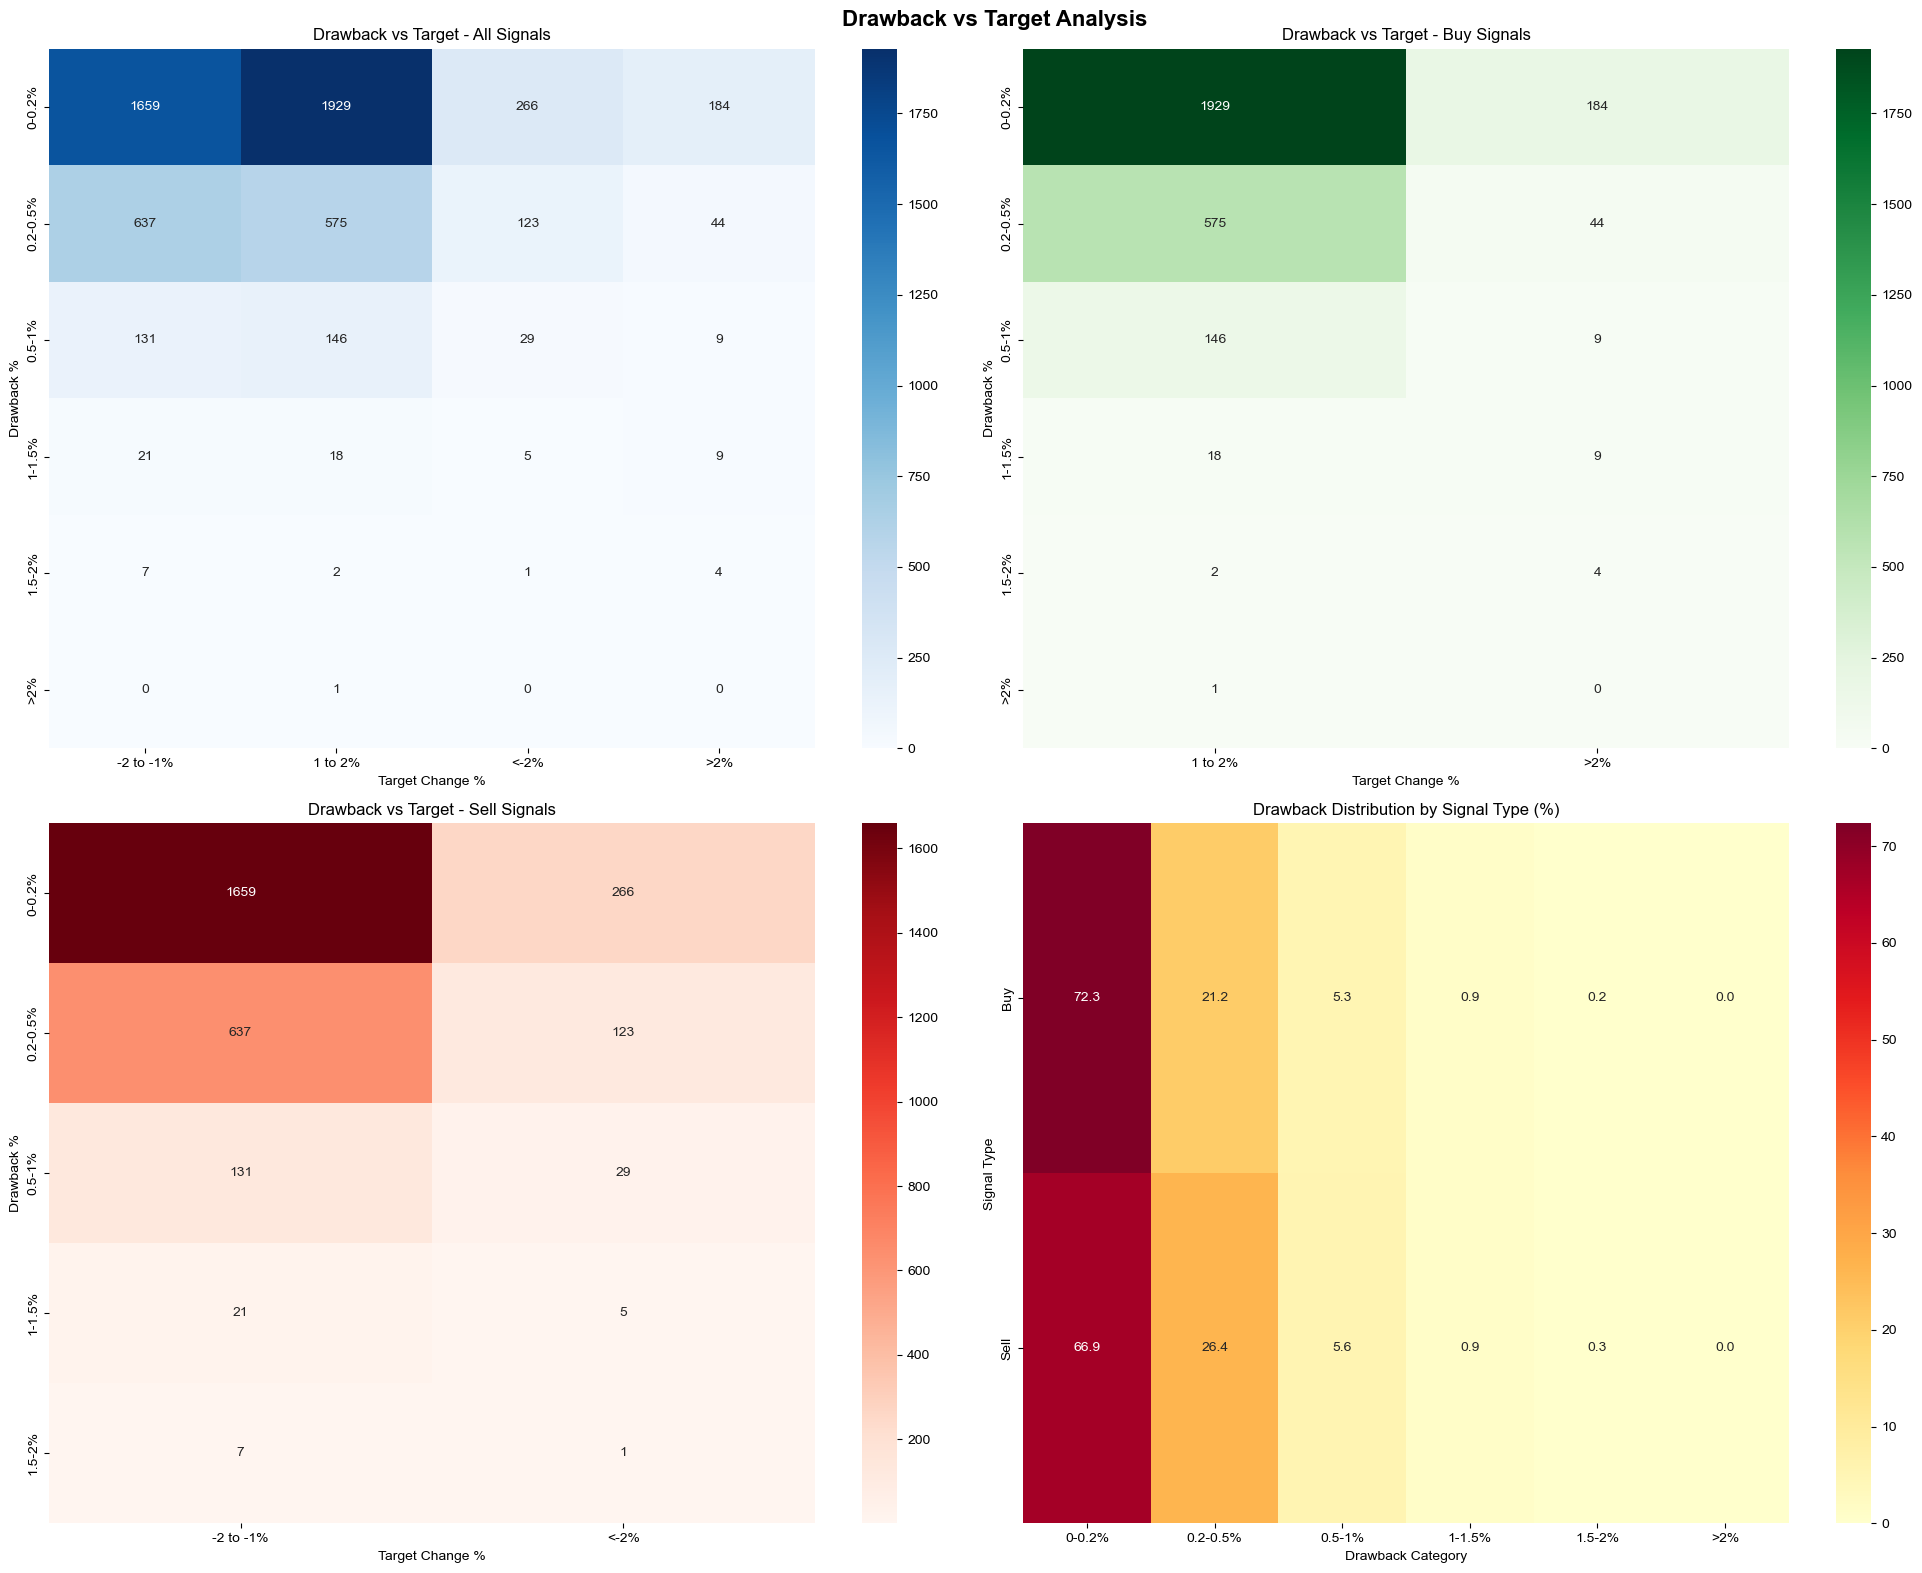

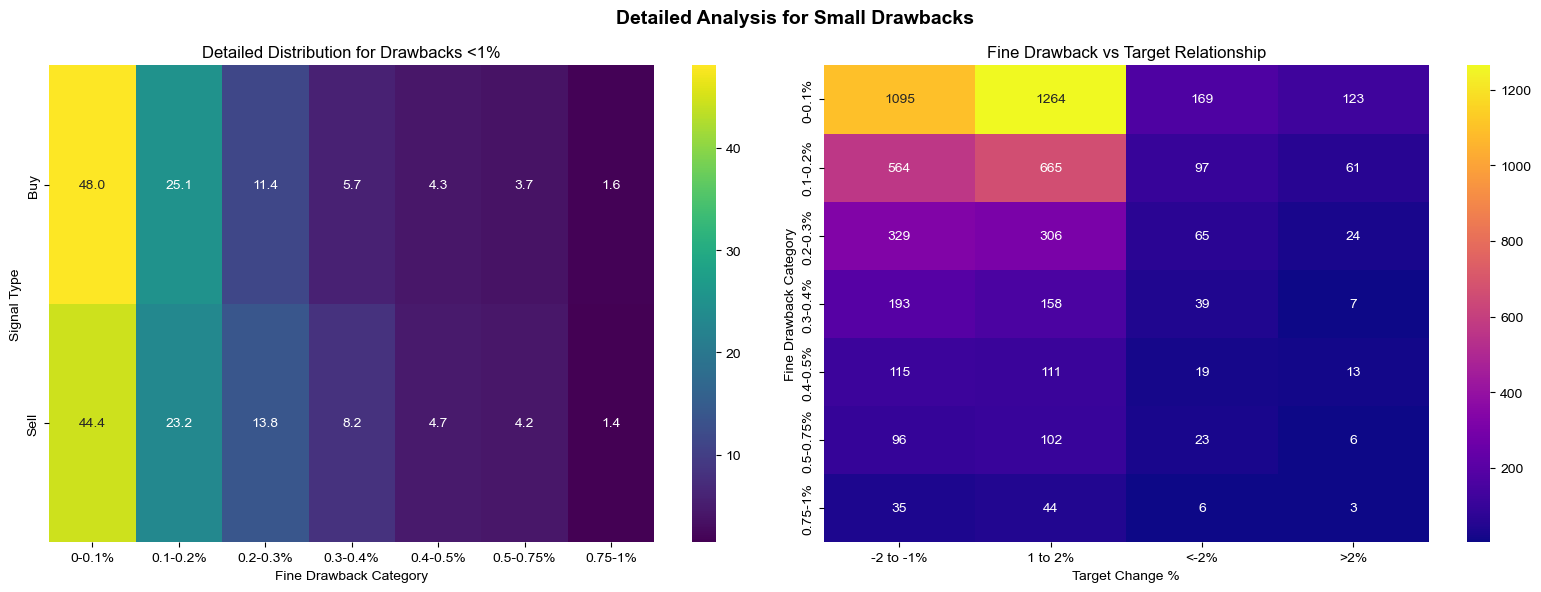

=== Heatmaps Summary ===
Total Signals: 5800
Buy Signals: 2921 (50.4%)
Sell Signals: 2879 (49.6%)
Signals with Drawback <1%: 5732 (98.8%)

=== Drawback Distribution by Signal Type (Percentage) ===
Drawback_Cat  0-0.2%  0.2-0.5%  0.5-1%  1-1.5%  1.5-2%  >2%
Signal                                                     
Buy             72.3      21.2     5.3     0.9     0.2  0.0
Sell            66.9      26.4     5.6     0.9     0.3  0.0

=== Fine Distribution for Small Drawbacks ===
Fine_Drawback_Cat  0-0.1%  0.1-0.2%  0.2-0.3%  0.3-0.4%  0.4-0.5%  0.5-0.75%  \
Signal                                                                         
Buy                  48.0      25.1      11.4       5.7       4.3        3.7   
Sell                 44.4      23.2      13.8       8.2       4.7        4.2   

Fine_Drawback_Cat  0.75-1%  
Signal                      
Buy                    1.6  
Sell                   1.4  


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# تحضير البيانات للـ heatmaps
def prepare_heatmap_data(results_df):
    # إنشاء فئات للانعكاس والتغير المستهدف
    def categorize_drawback(pct):
        abs_pct = abs(pct)
        if abs_pct <= 0.2:
            return "0-0.2%"
        elif abs_pct <= 0.5:
            return "0.2-0.5%"
        elif abs_pct <= 1.0:
            return "0.5-1%"
        elif abs_pct <= 1.5:
            return "1-1.5%"
        elif abs_pct <= 2.0:
            return "1.5-2%"
        else:
            return ">2%"
    
    def categorize_target(pct):
        if pct <= -2:
            return "<-2%"
        elif pct <= -1:
            return "-2 to -1%"
        elif pct <= -0.5:
            return "-1 to -0.5%"
        elif pct <= 0:
            return "-0.5 to 0%"
        elif pct <= 0.5:
            return "0 to 0.5%"
        elif pct <= 1:
            return "0.5 to 1%"
        elif pct <= 2:
            return "1 to 2%"
        else:
            return ">2%"
    
    results_df['Drawback_Cat'] = results_df['Max_Drawback_Pct'].apply(categorize_drawback)
    results_df['Target_Cat'] = results_df['Target_Change_Pct'].apply(categorize_target)
    
    return results_df

# تحضير البيانات
results_df = prepare_heatmap_data(results_df)

# إعداد الرسم
plt.rcParams['font.family'] = ['Arial', 'DejaVu Sans']
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Drawback vs Target Analysis', fontsize=16, fontweight='bold')

# 1. Heatmap للعلاقة بين الانعكاس والهدف - الكل
pivot_all = pd.crosstab(results_df['Drawback_Cat'], results_df['Target_Cat'])
sns.heatmap(pivot_all, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Drawback vs Target - All Signals')
axes[0,0].set_xlabel('Target Change %')
axes[0,0].set_ylabel('Drawback %')

# 2. Heatmap لإشارات الشراء
buy_data = results_df[results_df['Signal'] == 'Buy']
if len(buy_data) > 0:
    pivot_buy = pd.crosstab(buy_data['Drawback_Cat'], buy_data['Target_Cat'])
    sns.heatmap(pivot_buy, annot=True, fmt='d', cmap='Greens', ax=axes[0,1])
    axes[0,1].set_title('Drawback vs Target - Buy Signals')
    axes[0,1].set_xlabel('Target Change %')
    axes[0,1].set_ylabel('Drawback %')

# 3. Heatmap لإشارات البيع
sell_data = results_df[results_df['Signal'] == 'Sell']
if len(sell_data) > 0:
    pivot_sell = pd.crosstab(sell_data['Drawback_Cat'], sell_data['Target_Cat'])
    sns.heatmap(pivot_sell, annot=True, fmt='d', cmap='Reds', ax=axes[1,0])
    axes[1,0].set_title('Drawback vs Target - Sell Signals')
    axes[1,0].set_xlabel('Target Change %')
    axes[1,0].set_ylabel('Drawback %')

# 4. Heatmap للنسب المئوية - توزيع الانعكاس حسب نوع الإشارة
signal_drawback = pd.crosstab(results_df['Signal'], results_df['Drawback_Cat'], normalize='index') * 100
sns.heatmap(signal_drawback, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1,1])
axes[1,1].set_title('Drawback Distribution by Signal Type (%)')
axes[1,1].set_xlabel('Drawback Category')
axes[1,1].set_ylabel('Signal Type')

plt.tight_layout()
plt.show()

# Heatmap إضافي - تفصيلي أكثر للانعكاس الصغير
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
fig2.suptitle('Detailed Analysis for Small Drawbacks', fontsize=14, fontweight='bold')

# فلترة البيانات للانعكاس أقل من 1%
small_drawback = results_df[abs(results_df['Max_Drawback_Pct']) <= 1.0].copy()

def fine_categorize_drawback(pct):
    abs_pct = abs(pct)
    if abs_pct <= 0.1:
        return "0-0.1%"
    elif abs_pct <= 0.2:
        return "0.1-0.2%"
    elif abs_pct <= 0.3:
        return "0.2-0.3%"
    elif abs_pct <= 0.4:
        return "0.3-0.4%"
    elif abs_pct <= 0.5:
        return "0.4-0.5%"
    elif abs_pct <= 0.75:
        return "0.5-0.75%"
    else:
        return "0.75-1%"

small_drawback['Fine_Drawback_Cat'] = small_drawback['Max_Drawback_Pct'].apply(fine_categorize_drawback)

# Heatmap للتوزيع التفصيلي
fine_signal_drawback = pd.crosstab(small_drawback['Signal'], small_drawback['Fine_Drawback_Cat'], normalize='index') * 100
sns.heatmap(fine_signal_drawback, annot=True, fmt='.1f', cmap='viridis', ax=axes2[0])
axes2[0].set_title('Detailed Distribution for Drawbacks <1%')
axes2[0].set_xlabel('Fine Drawback Category')
axes2[0].set_ylabel('Signal Type')

# Heatmap للعلاقة بين الانعكاس التفصيلي والهدف
fine_pivot = pd.crosstab(small_drawback['Fine_Drawback_Cat'], small_drawback['Target_Cat'])
sns.heatmap(fine_pivot, annot=True, fmt='d', cmap='plasma', ax=axes2[1])
axes2[1].set_title('Fine Drawback vs Target Relationship')
axes2[1].set_xlabel('Target Change %')
axes2[1].set_ylabel('Fine Drawback Category')

plt.tight_layout()
plt.show()

# إحصائيات سريعة
print("=== Heatmaps Summary ===")
print(f"Total Signals: {len(results_df)}")
print(f"Buy Signals: {len(buy_data)} ({len(buy_data)/len(results_df)*100:.1f}%)")
print(f"Sell Signals: {len(sell_data)} ({len(sell_data)/len(results_df)*100:.1f}%)")
print(f"Signals with Drawback <1%: {len(small_drawback)} ({len(small_drawback)/len(results_df)*100:.1f}%)")

# طباعة الجداول المحورية للمراجعة
print("\n=== Drawback Distribution by Signal Type (Percentage) ===")
print(signal_drawback.round(1))

print("\n=== Fine Distribution for Small Drawbacks ===")
print(fine_signal_drawback.round(1))

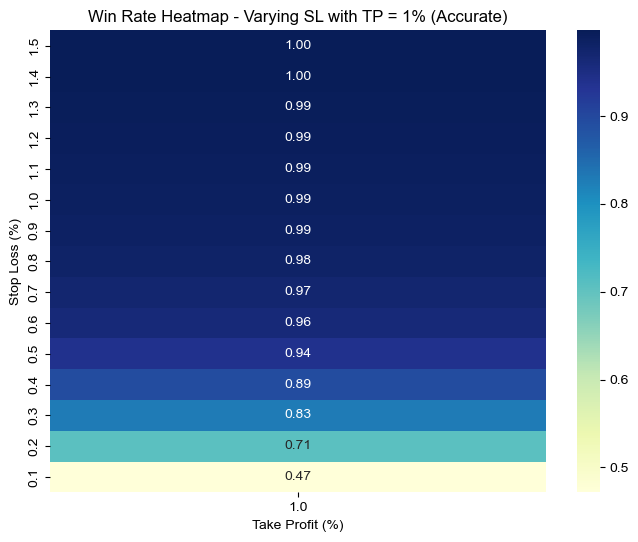

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# إعداد قيم SL
sl_values = np.round(np.arange(0.1, 1.6, 0.1), 2)
tp_fixed = 1.0
heatmap_data = []

# الحساب لكل نسبة SL
for sl in sl_values:
    wins = 0
    losses = 0

    for idx in range(len(df) - 24):
        row = df.iloc[idx]
        direction = row['Signal']
        if direction == 0:
            continue

        entry_price = row['Close']
        future_data = df.iloc[idx+1 : idx+25]

        if direction == 1:  # شراء
            tp_price = entry_price * (1 + tp_fixed / 100)
            sl_price = entry_price * (1 - sl / 100)

            for _, candle in future_data.iterrows():
                if candle['High'] >= tp_price:
                    wins += 1
                    break
                elif candle['Low'] <= sl_price:
                    losses += 1
                    break

        elif direction == -1:  # بيع
            tp_price = entry_price * (1 - tp_fixed / 100)
            sl_price = entry_price * (1 + sl / 100)

            for _, candle in future_data.iterrows():
                if candle['Low'] <= tp_price:
                    wins += 1
                    break
                elif candle['High'] >= sl_price:
                    losses += 1
                    break

    total = wins + losses
    win_rate = wins / total if total > 0 else np.nan
    heatmap_data.append([tp_fixed, sl, win_rate])

# تحويل النتائج لهيت ماب
heatmap_df = pd.DataFrame(heatmap_data, columns=['TP', 'SL', 'WinRate'])
heatmap_df['SL'] = heatmap_df['SL'].round(2)
pivot_df = heatmap_df.pivot(index='SL', columns='TP', values='WinRate')
pivot_df = pivot_df.sort_index(ascending=False)

# رسم الهـيت مـاب
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Win Rate Heatmap - Varying SL with TP = 1% (Accurate)")
plt.xlabel("Take Profit (%)")
plt.ylabel("Stop Loss (%)")
plt.show()


In [26]:
df

,Gmt time,Open,High,Low,Close,time_gap,date,hour,minute,is_Sydney,...,ema_cross,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,macd_cross,ADX_14,DMP_14,DMN_14,is_trend_strong,Signal
50,2020-01-02 12:30:00,1522.097770,1523.158,1522.097770,1522.72225,15.0,2020-01-02,12,30,0,...,1,0.634866,0.201206,0.433660,1,18.481485,22.673299,9.054034,0,0
51,2020-01-02 12:45:00,1522.410010,1523.615,1522.410010,1523.10900,15.0,2020-01-02,12,45,0,...,1,0.714007,0.224278,0.489730,1,20.762910,23.942008,8.300907,0,0
52,2020-01-02 13:00:00,1522.759505,1524.128,1522.648000,1523.32975,15.0,2020-01-02,13,0,0,...,1,0.785485,0.236604,0.548881,1,23.273353,25.004577,7.478131,0,0
53,2020-01-02 13:15:00,1523.044628,1525.215,1523.044628,1524.04900,15.0,2020-01-02,13,15,0,...,1,0.889911,0.272824,0.617087,1,26.258451,28.398989,6.465975,1,0
54,2020-01-02 13:30:00,1523.546814,1525.855,1522.998000,1524.67575,15.0,2020-01-02,13,30,0,...,1,1.011582,0.315596,0.695986,1,29.313448,27.433423,5.425051,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115784,2024-12-31 22:45:00,2624.227034,2624.255,2624.227034,2624.25500,15.0,2024-12-31,22,45,1,...,1,1.024956,-0.334108,1.359064,0,38.826063,16.705654,8.439794,1,0
115785,2024-12-31 23:00:00,2624.241017,2624.255,2624.241017,2624.25500,15.0,2024-12-31,23,0,1,...,1,0.968435,-0.312503,1.280939,0,38.400787,16.695317,8.434571,1,0
115786,2024-12-31 23:15:00,2624.248008,2624.255,2624.248008,2624.25500,15.0,2024-12-31,23,15,1,...,1,0.913116,-0.294258,1.207374,0,38.005887,16.689756,8.431762,1,0
115787,2024-12-31 23:30:00,2624.251504,2624.255,2624.251504,2624.25500,15.0,2024-12-31,23,30,1,...,1,0.859369,-0.278404,1.137773,0,37.639195,16.686763,8.430250,1,0


In [32]:
df.columns

Index(['Gmt time', 'Open', 'High', 'Low', 'Close', 'time_gap', 'date', 'hour',
       'minute', 'is_Sydney', 'is_Tokyo', 'is_London', 'is_NewYork',
       'is_OffHours', 'return', 'return_1h', 'return_4h', 'return_12h',
       'return_24h', 'ha_std_4h', 'ema_10', 'ema_50', 'ema_cross',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'macd_cross',
       'ADX_14', 'DMP_14', 'DMN_14', 'is_trend_strong', 'Signal'],
      dtype='object')

In [84]:
df_k = df.drop(columns=['date'])

corn = []

for x in df_k.columns:
    if x != 'Signal':  # تجنب مقارنة Signal مع نفسه
        cor = df_k['Signal'].corr(df_k[x])
        corn.append({'name': x, 'correlation': cor})

cor_df = pd.DataFrame(corn)

# ترتيب من الأعلى إلى الأقل
cor_df = cor_df.sort_values(by='correlation', ascending=False).reset_index(drop=True)

print(cor_df)


               name  correlation
0        return_24h     0.335781
1        return_12h     0.255232
2         return_4h     0.236306
3         return_1h     0.093714
4         ema_cross     0.032615
5            return     0.030950
6            DMP_14     0.026185
7     MACDs_12_26_9     0.020986
8      MACD_12_26_9     0.019707
9        is_NewYork     0.015974
10             hour     0.014669
11         Gmt time     0.005514
12      is_OffHours     0.002943
13         time_gap     0.000633
14           minute     0.000311
15    MACDh_12_26_9    -0.000275
16       macd_cross    -0.000449
17        is_Sydney    -0.000860
18           ADX_14    -0.003355
19  is_trend_strong    -0.004316
20         is_Tokyo    -0.009299
21        is_London    -0.012020
22        ha_std_4h    -0.028746
23              Low    -0.031045
24            Close    -0.031108
25             High    -0.031221
26           ema_10    -0.031310
27             Open    -0.031333
28           ema_50    -0.031759
29        

In [87]:
df

,Gmt time,Open,High,Low,Close,time_gap,date,hour,minute,is_Sydney,...,ema_cross,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,macd_cross,ADX_14,DMP_14,DMN_14,is_trend_strong,Signal
50,2020-01-02 12:30:00,1522.097770,1523.158,1522.097770,1522.72225,15.0,2020-01-02,12,30,0,...,1,0.634866,0.201206,0.433660,1,18.481485,22.673299,9.054034,0,0
51,2020-01-02 12:45:00,1522.410010,1523.615,1522.410010,1523.10900,15.0,2020-01-02,12,45,0,...,1,0.714007,0.224278,0.489730,1,20.762910,23.942008,8.300907,0,0
52,2020-01-02 13:00:00,1522.759505,1524.128,1522.648000,1523.32975,15.0,2020-01-02,13,0,0,...,1,0.785485,0.236604,0.548881,1,23.273353,25.004577,7.478131,0,0
53,2020-01-02 13:15:00,1523.044628,1525.215,1523.044628,1524.04900,15.0,2020-01-02,13,15,0,...,1,0.889911,0.272824,0.617087,1,26.258451,28.398989,6.465975,1,0
54,2020-01-02 13:30:00,1523.546814,1525.855,1522.998000,1524.67575,15.0,2020-01-02,13,30,0,...,1,1.011582,0.315596,0.695986,1,29.313448,27.433423,5.425051,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115784,2024-12-31 22:45:00,2624.227034,2624.255,2624.227034,2624.25500,15.0,2024-12-31,22,45,1,...,1,1.024956,-0.334108,1.359064,0,38.826063,16.705654,8.439794,1,0
115785,2024-12-31 23:00:00,2624.241017,2624.255,2624.241017,2624.25500,15.0,2024-12-31,23,0,1,...,1,0.968435,-0.312503,1.280939,0,38.400787,16.695317,8.434571,1,0
115786,2024-12-31 23:15:00,2624.248008,2624.255,2624.248008,2624.25500,15.0,2024-12-31,23,15,1,...,1,0.913116,-0.294258,1.207374,0,38.005887,16.689756,8.431762,1,0
115787,2024-12-31 23:30:00,2624.251504,2624.255,2624.251504,2624.25500,15.0,2024-12-31,23,30,1,...,1,0.859369,-0.278404,1.137773,0,37.639195,16.686763,8.430250,1,0


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in

KeyboardInterrupt: 

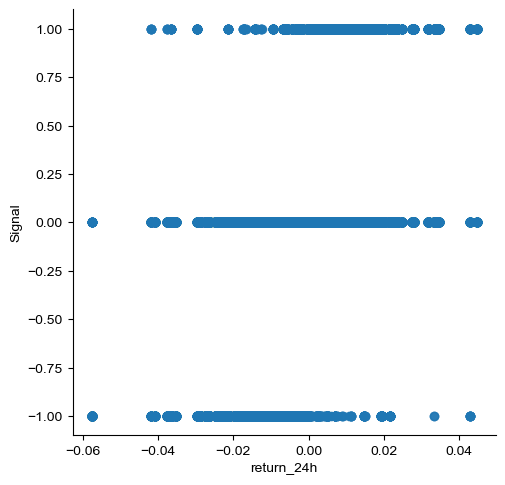

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x='return_24h', y='Signal', data=df, logistic=True)
plt.title("Non-linear relationship (return_24h vs Signal)")
plt.show()


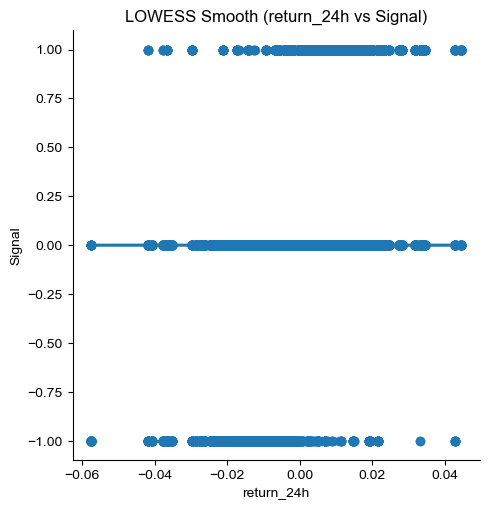

In [90]:
sns.lmplot(x='return_24h', y='Signal', data=df, lowess=True)
plt.title("LOWESS Smooth (return_24h vs Signal)")
plt.show()


In [93]:
from xgboost import XGBClassifier
import shap

# تأكد من تجهيز البيانات:
X = df.drop(columns=['Signal'])  # أو اختر الأعمدة المناسبة فقط
y = df['Signal']

# (اختياري) لو في أعمدة غير رقمية:
#X = X.select_dtypes(include='number')

# تدريب النموذج
model = XGBClassifier()
model.fit(X, y)

# SHAP explainer
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# عرض أهمية الميزات
shap.summary_plot(shap_values, X)


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]

100%|===================| 112777/112860 [14:46<00:00]        

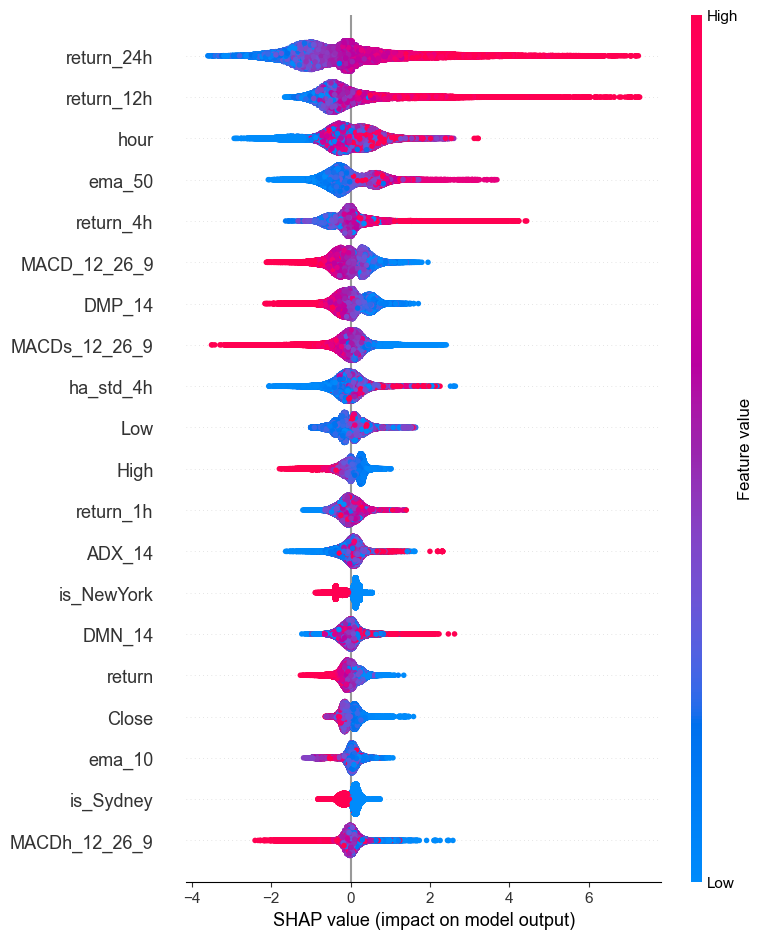

In [94]:
from xgboost import XGBClassifier
import shap
import pandas as pd

# 1. إنشاء نسخة من df لتجنب تعديل الأصل
df_temp = df.copy()

# 2. تصفية البيانات للتدريب فقط على الصفوف التي فيها Signal = 0 أو 1
df_temp = df_temp[df_temp['Signal'].isin([0, 1])]

# 3. فصل الميزات والهدف
X = df_temp.drop(columns=['Signal'])
y = df_temp['Signal']

# 4. تحديد الأعمدة الرقمية فقط (لتجنب مشاكل مع SHAP أو XGBoost)
X = X.select_dtypes(include='number')

# 5. تدريب نموذج XGBoost
model = XGBClassifier()
model.fit(X, y)

# 6. استخدام SHAP لشرح النموذج
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# 7. رسم أهمية الميزات
shap.summary_plot(shap_values, X)


In [104]:
df['Signal'].value_counts()

Signal
 0    109939
 1      2921
-1      2879
Name: count, dtype: int64

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import shap


In [108]:
# بياناتك الأصلية
X = df.drop(columns=['Signal'])
y = df['Signal']  # عدّل حسب اسم العمود المستهدف

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# تدريب نموذج (مثلاً RandomForest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115739 entries, 50 to 115788
Data columns (total 32 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Gmt time         115739 non-null  datetime64[ns]
 1   Open             115739 non-null  float64       
 2   High             115739 non-null  float64       
 3   Low              115739 non-null  float64       
 4   Close            115739 non-null  float64       
 5   time_gap         115739 non-null  float64       
 6   date             115739 non-null  object        
 7   hour             115739 non-null  int32         
 8   minute           115739 non-null  int32         
 9   is_Sydney        115739 non-null  int64         
 10  is_Tokyo         115739 non-null  int64         
 11  is_London        115739 non-null  int64         
 12  is_NewYork       115739 non-null  int64         
 13  is_OffHours      115739 non-null  int64         
 14  return           11

In [114]:
df_ = df.drop(columns=['date','Open','High','Low'])
corr = df_.corr()
corr.style.background_gradient(axis=None)

,Gmt time,Close,time_gap,hour,minute,is_Sydney,is_Tokyo,is_London,is_NewYork,is_OffHours,return,return_1h,return_4h,return_12h,return_24h,ha_std_4h,ema_10,ema_50,ema_cross,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,macd_cross,ADX_14,DMP_14,DMN_14,is_trend_strong,Signal
Gmt time,1.000000,0.743987,0.014177,-0.014598,-0.000068,0.004749,0.010975,-0.003386,-0.002655,-0.006948,0.001987,0.003168,0.003590,0.008001,0.010733,-0.003364,0.744031,0.744219,0.000196,0.015427,0.000132,0.016318,0.008554,0.037481,0.053476,-0.004517,0.028795,0.005514
Close,0.743987,1.000000,0.015336,-0.017813,-0.000069,0.005727,0.012937,-0.003858,-0.003377,-0.014187,0.005581,0.006582,0.008004,0.020493,0.018397,0.099305,0.999942,0.999641,0.056191,0.042678,0.000144,0.045215,-0.000411,0.018496,0.069074,-0.005533,0.008872,-0.031108
time_gap,0.014177,0.015336,1.000000,-0.075459,-0.073321,0.060049,0.058947,-0.036216,-0.035760,-0.004151,0.036553,0.010848,0.006345,-0.000910,-0.000774,0.003909,0.015166,0.015172,-0.000627,0.000016,0.005035,-0.001573,0.002233,0.005653,0.056134,0.039207,0.000286,0.000633
hour,-0.014598,-0.017813,-0.075459,1.000000,-0.000050,-0.390587,-0.840763,0.002439,0.554160,0.105443,-0.000568,-0.000873,-0.005505,-0.007266,-0.000627,-0.064837,-0.017686,-0.017210,-0.026018,-0.027676,-0.008168,-0.026771,-0.002717,0.015839,-0.107809,-0.035527,-0.001351,0.014669
minute,-0.000068,-0.000069,-0.073321,-0.000050,1.000000,-0.000003,0.000021,0.000053,-0.000043,0.000002,-0.000736,0.000017,0.000018,0.000028,0.000016,0.000030,-0.000064,-0.000064,-0.000242,-0.000008,-0.000084,0.000019,0.003435,-0.000242,-0.013483,-0.010941,0.000458,0.000311
is_Sydney,0.004749,0.005727,0.060049,-0.390587,-0.000003,1.000000,0.566505,-0.600915,-0.600494,-0.058982,0.007914,0.012533,0.019205,0.005592,0.001928,-0.192637,0.005520,0.005204,0.007437,0.022213,0.018450,0.017731,0.007991,-0.087807,0.066884,-0.015436,-0.084110,-0.000860
is_Tokyo,0.010975,0.012937,0.058947,-0.840763,0.000021,0.566505,1.000000,-0.325932,-0.606379,-0.059560,0.003357,0.005276,0.011898,0.006787,0.000814,-0.081171,0.012777,0.012345,0.019858,0.026565,0.010979,0.024705,0.000028,-0.044285,0.092642,0.016754,-0.032800,-0.009299
is_London,-0.003386,-0.003858,-0.036216,0.002439,0.000053,-0.600915,-0.325932,1.000000,0.122854,-0.058787,-0.004406,-0.006877,-0.017946,-0.002707,-0.001602,0.300254,-0.003724,-0.003636,0.011275,-0.009875,-0.015158,-0.005686,-0.002080,0.056848,0.000288,0.032134,0.077234,-0.012020
is_NewYork,-0.002655,-0.003377,-0.035760,0.554160,-0.000043,-0.600494,-0.606379,0.122854,1.000000,-0.058746,-0.005496,-0.008610,-0.008828,-0.008457,-0.001781,0.212670,-0.003202,-0.002779,-0.019986,-0.024412,-0.009117,-0.023010,0.000806,0.077804,-0.070185,0.014269,0.063127,0.015974
is_OffHours,-0.006948,-0.014187,-0.004151,0.105443,0.000002,-0.058982,-0.059560,-0.058787,-0.058746,1.000000,0.000719,0.001126,0.003044,0.006228,0.000343,-0.043808,-0.014204,-0.014262,0.001638,0.001716,-0.002976,0.002759,-0.010328,-0.010078,-0.017337,-0.012860,-0.009348,0.002943
